In [189]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
  further sources:
  https://keras.io/examples/variational_autoencoder_deconv/ (15.12.2021)
  https://pythonprogramming.net/autoencoders-tutorial/ (15.12.2021)
  https://www.geeksforgeeks.org/role-of-kl-divergence-in-variational-autoencoders/ (15.12.2021)
  http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/ (16.12.2021)
  https://jaketae.github.io/study/vae/ (16.12.2021)
  https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb (16.12.2021)
  https://www.tensorflow.org/tutorials/generative/cvae (16.12.2021)

'''

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

TODO:
- document

In [190]:
# disable eager mode and enable graph mode
tf.compat.v1.disable_eager_execution()

In [191]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [192]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
latent_dim = 2
batch_size = 128
hidden_size = 256
no_epochs = 100
validation_split = 0.2
verbosity = 1
num_channels = 1
input_shape = (img_height, img_width, num_channels)

In [193]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [194]:
# # =================
# # Encoder
# # =================

# Definition
i = Input(shape=input_shape, name='encoder_input')
x = Flatten()(i)
x = Dense(hidden_size, activation="relu")(x)
x = Dense(hidden_size, activation='relu')(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 784)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense_66 (Dense)               (None, 256)          200960      ['flatten_13[0][0]']             
                                                                                                  
 dense_67 (Dense)               (None, 256)          65792       ['dense_66[0][0]']               
                                                                                            

In [195]:
# =================
# Decoder
# =================

# Definition
d_i = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(hidden_size, activation="relu")(d_i)
x = Dense(hidden_size, activation="relu")(x)
x = Dense(np.prod(list(input_shape)), activation="relu")(x)
o = Reshape(input_shape)(x)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_68 (Dense)            (None, 256)               768       
                                                                 
 dense_69 (Dense)            (None, 256)               65792     
                                                                 
 dense_70 (Dense)            (None, 784)               201488    
                                                                 
 reshape_12 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


In [196]:
# =================
# Variational Autoencoder
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2]) # output is decoded output z of encoder with input i
vae = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               267780    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         268048    
                                                                 
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Define loss function
def elbo_loss(true, pred):
    # Reconstruction loss with mean squared error because data is not binarised
    reconstruction_loss = keras.losses.mean_squared_error(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [198]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt, loss=elbo_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs=no_epochs*2, batch_size=batch_size, validation_data=(input_test, input_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 81us/sample - loss: 48.9382 - val_loss: 44.7926
Epoch 2/200
60000/60000 [==============================] - 3s 51us/sample - loss: 43.2189 - val_loss: 42.0320
Epoch 3/200
60000/60000 [==============================] - 4s 62us/sample - loss: 41.5459 - val_loss: 40.9985
Epoch 4/200
60000/60000 [==============================] - 4s 64us/sample - loss: 40.5110 - val_loss: 40.3999
Epoch 5/200
60000/60000 [==============================] - 4s 64us/sample - loss: 39.7742 - val_loss: 39.5380
Epoch 6/200
60000/60000 [==============================] - 4s 64us/sample - loss: 39.2626 - val_loss: 39.1542
Epoch 7/200
60000/60000 [==============================] - 4s 63us/sample - loss: 38.8884 - val_loss: 38.8194
Epoch 8/200
60000/60000 [==============================] - 4s 63us/sample - loss: 38.6188 - val_loss: 38.5487
Epoch 9/200
60000/60000 [==============================] - 4s 63us/sam

### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

The posterior represents the output of the encoder and the likelihood represents the output of the decoder.
In case of the decoder, we do not need any activation function for the mean and the standard deviation because we need the real values between zero and one in order to produce a digit.
The posterior samples $z$ by $z = \mu + e^\frac{\sigma}{2} * \epsilon$ with epsilon chosen randomly from a Normal distribution. Therefore, we should not modify the mean because it determines which digit we will receive. The standard deviation has less of an effect, and it might be useful to avoid that the second part of the sum gets to small because in order to provide samples that differ from the mean. A possible activation function is ReLU. But at the same time, we do not want to deviate too much such that we still classify the right digit. So, softplus might be an alternative for an activation function for the standard deviation.
However, we have chosen to use no activation function for posterior and likelihood because we receive the best results without them.

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

At the moment, we generate digits by randomly choosing the input of the decoder. The VAE has bad results for decoder inputs close to zero and at the borders. The probability to receive a output of the encoder that is a good input for the decoder is higher for reconstructed digits because they already come from a distribution that represents an existing digit. If we know outputs of the encoder that lead to good results for the reconstruction, we can reuse and slightly modify them to achieve better results for generation.

### Subtask 3: Train the VAE

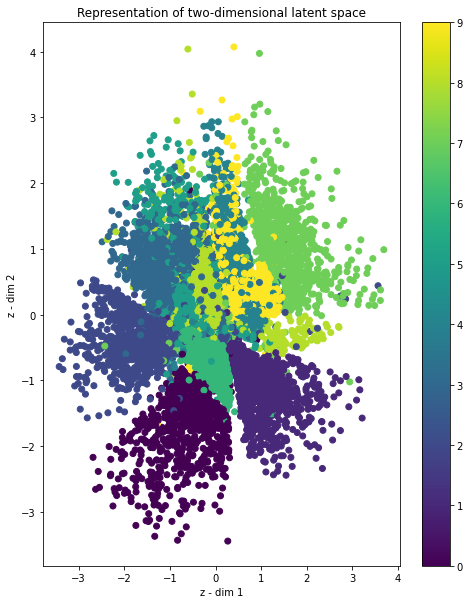

In [199]:
# =================
# adapted from: https://keras.io/examples/variational_autoencoder_deconv/
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.title("Representation of two-dimensional latent space")
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

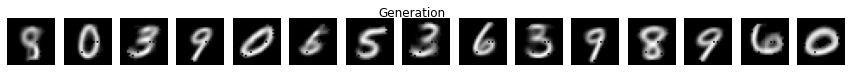

In [200]:
def vis_generation(num_samples):
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    fig.suptitle('Generation')
    for i in range(num_samples):
        z_sample = np.random.normal(size=latent_dim)
        out = decoder.predict(np.array([z_sample]))
        out_reshaped = out[0].reshape(img_width, img_height, num_channels)

        axs[i].imshow(out_reshaped, cmap="gray")
        axs[i].axis('off')

vis_generation(15)

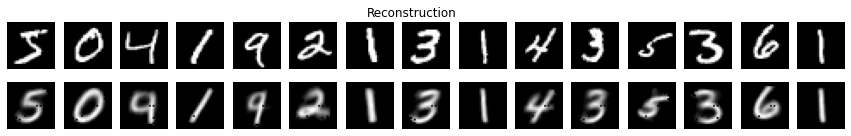

In [201]:
def vis_reconstruction(num_samples):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    fig.suptitle('Reconstruction')
    for i in range(num_samples):
        axs[0][i].imshow(input_train[i], cmap="gray")
        axs[0][i].axis('off')
    for i in range(num_samples):
        out = vae.predict([input_train[i].reshape(-1, 28, 28, 1)])[0]
        axs[1][i].imshow(out, cmap="gray")
        axs[1][i].axis('off')


vis_reconstruction(15)

### Subtask 4: Plot the loss curve

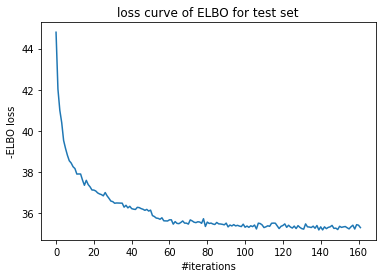

In [202]:
#print(vae.history.history)
loss_history = history.history['val_loss']

plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('-ELBO loss')
plt.show()

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results:
The system takes longer to converge because there are more parameters to train (more than 200 epochs). The loss is smaller compared to latent_dim=2.
The generation of the digits works not too well, due to the big ranges for input values that are chosen randomly.
The reconstruction of the digits has better results compared to latent_dim=2